This notebook reproduces table 1 and figure 4 of the paper : Amortized Tree Generation for Bottom-up Synthesis Planning and Synthesizable Molecular Design.

#### Reproducing table 1 :
Inspired from script "23-evaluate-predictions.py"

In [4]:
import numpy as np
import pandas as pd
from Analysis import sanitize, metrics_for_table1, metrics_for_figure4

"Dataframe with target- and prediction smiles and similarities (*.csv.gz)."
bblocks_original = "../results/bblocks/original/decoded_results.csv.gz"
chembl_original = "../results/chembl/original/decoded_results.csv.gz"
zinc_original = "../results/zinc/original/decoded_results.csv.gz"

input_file = chembl_original

# Clean-up the data: separating recovered (similarity =1) from unrecovered (similarity $\in ]0,1[$) and discarding NaNs (similarity = 0)
recovered, unrecovered, n_total = sanitize(input_file)

In [4]:
# Compute N = number of molecules used, Recovery Rate, Average Similarity, KL Divergence, FC Distance
recovery_rate, average_similarity, kl_divergence, fc_distance = metrics_for_table1(recovered, unrecovered, n_total)

KeyboardInterrupt: 

In [ ]:
d = {"N": n_total, "Recovery Rate % ": recovery_rate, "Average Similarity ": average_similarity, "KL Divergence ": kl_divergence, "FC Distance ": fc_distance}
pd.Series(data=d)

Recap of results obtained :
original = using pretrained
reproduced = using re-trained

\begin{table}
\begin{tabular}{lrrrrr}
\hline
Dataset                          & N & Recovery Rate & Average Similarity & KL Divergence & FC Distance \\ \hline
(Bblocks, original)   & 10000  &  80.86  \%   &  0.622   &  [0.9998, 0.927]  &  [0.00027, 2.359]      \\
(Bblocks, reproduced) &   &               &                    &               &             \\
(Zinc, original)   & 10000  &  18.98  \%   &  0.571   &  [0.978, 0.749]  &  [0.238, 1.621]     \\
(Zinc, reproduced) &   &               &                    &               &             \\
(ChEMBL, original)  &  10000  &  6.05  \%   &  0.466   &  [0.989, 0.959]  &  [0.027, 2.188]      \\
(ChEMBL, reproduced)             &   &               &                    &               &             \\\hline
\end{tabular}
\end{table}

### Reproducing figure 4 :


Compare the SA score (Synthesis Accessibility), LogP score (Octanol-water Partition Coefficient), molecular weight and QED score (Quantitative Estimate of Drug-likeness) of target and decoded molecules for the original dataset (bblocks) and ChLEMB dataset.

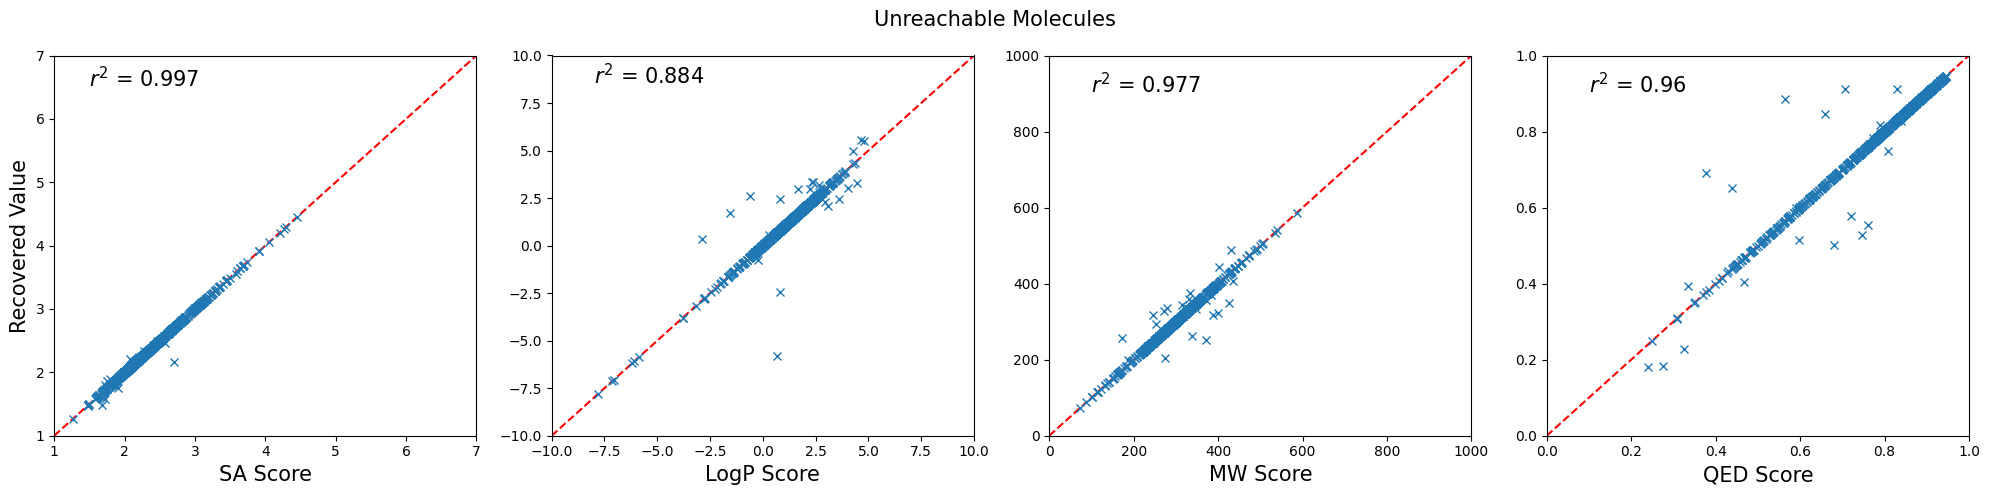

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

title = None
if input_file == bblocks_original:
    title = 'Reachable'
elif input_file == chembl_original:
    title = 'Unreachable'

if title != None:
    score_target, score_decoded = metrics_for_figure4(recovered)

    xlim = [[1,7],[-10,10],[0,1000],[0,1]]
    ylim = [[1,7],[-10,10],[0,1000],[0,1]]
    text_pos = [[1.5,6.5],[-8,8.5],[100,900],[0.1,0.9]]

    fig, axs = plt.subplots(1,4, figsize=(20, 5))
    fig.suptitle(title+" Molecules", fontsize=15)
    for idx, func in enumerate("SA LogP MW QED".split()):
        target = score_target[func]
        decoded = score_decoded[func]

        # compute regression score function
        r2 = r2_score(decoded,target)

        axs[idx].plot(np.linspace(xlim[idx][0], xlim[idx][1], 10), np.linspace(ylim[idx][0], ylim[idx][1], 10), 'r--')
        axs[idx].plot(decoded, target, 'x')
        axs[idx].set_xlabel(func + " Score", fontsize=15)
        axs[idx].text(text_pos[idx][0],text_pos[idx][1], "$r^2$ = "+ '{:.3}'.format(r2), fontsize=15)
        axs[idx].set_xlim(xlim[idx])
        axs[idx].set_ylim(ylim[idx])

    axs[0].set_ylabel("Recovered Value", fontsize=15)
    fig.tight_layout()

    plt.savefig(title + "Figure4.png")